In [1]:
import keras
from keras.layers import Dense, Dropout
import librosa, librosa.display
import os
import scipy
import numpy as np
import pandas as pd
import scipy
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt


c:\users\ravindran\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.getcwd()

'C:\\Users\\Ravindran'

In [3]:
model = keras.models.load_model(r"C:\Users\Ravindran\Downloads\Emotion_Voice_Detection_Model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_8 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 216, 128)          82048     
_________________________________________________________________
activation_9 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 128)           82048     
__________

In [4]:
for layer in model.layers:
    layer.trainable =False
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_8 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 216, 128)          82048     
_________________________________________________________________
activation_9 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 128)           82048     
__________

216
216
216
216
216
216


NoBackendError: 

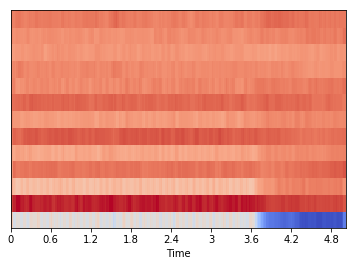

In [5]:
def getMFCCVectors(dir_path):
    col_names = ["File"]
    for i in range(216):
        col_names.append("f_{0}".format(i))
    df = pd.DataFrame(columns=col_names)
    files = os.listdir(dir_path)
    for wav_file in files:
            X, sample_rate = librosa.load(dir_path + '\\' + wav_file, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
            sample_rate = np.array(sample_rate)
            mfccs = librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13)
            librosa.display.specshow(mfccs, x_axis='time')
            mfccs = np.mean(mfccs,axis=0)
            feature = list(mfccs)
            print(len(mfccs))
            feature.insert(0,wav_file)
            #feature = np.insert(feature,0,wav_file,axis=0)
            df = df.append(pd.Series(feature,index=col_names),ignore_index=True)
    return df

df = getMFCCVectors(r"C:\Users\Ravindran\Downloads\wavfiles")

In [ ]:
df

In [6]:
class VoiceActivityDetector():
    """ Use signal energy to detect voice activity in wav file """
    
    def __init__(self, wave_input_filename):
        self._read_wav(wave_input_filename)._convert_to_mono()
        self.sample_window = 0.02 #20 ms
        self.sample_overlap = 0.01 #10ms
        self.speech_window = 0.5 #half a second
        self.speech_energy_threshold = 0.6 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
           
    def _read_wav(self, wave_file):
        self.rate, self.data = wf.read(wave_file)
        self.channels = len(self.data.shape)
        self.filename = wave_file
        return self
    
    def _convert_to_mono(self):
        if self.channels == 2 :
            self.data = np.mean(self.data, axis=1, dtype=self.data.dtype)
            self.channels = 1
        return self
    
    def _calculate_frequencies(self, audio_data):
        data_freq = np.fft.fftfreq(len(audio_data),1.0/self.rate)
        data_freq = data_freq[1:]
        return data_freq    
    
    def _calculate_amplitude(self, audio_data):
        data_ampl = np.abs(np.fft.fft(audio_data))
        data_ampl = data_ampl[1:]
        return data_ampl
        
    def _calculate_energy(self, data):
        data_amplitude = self._calculate_amplitude(data)
        data_energy = data_amplitude ** 2
        return data_energy
        
    def _znormalize_energy(self, data_energy):
        energy_mean = np.mean(data_energy)
        energy_std = np.std(data_energy)
        energy_znorm = (data_energy - energy_mean) / energy_std
        return energy_znorm
    
    def _connect_energy_with_frequencies(self, data_freq, data_energy):
        energy_freq = {}
        for (i, freq) in enumerate(data_freq):
            if abs(freq) not in energy_freq:
                energy_freq[abs(freq)] = data_energy[i] * 2
        return energy_freq
    
    def _calculate_normalized_energy(self, data):
        data_freq = self._calculate_frequencies(data)
        data_energy = self._calculate_energy(data)
        #data_energy = self._znormalize_energy(data_energy) #znorm brings worse results
        energy_freq = self._connect_energy_with_frequencies(data_freq, data_energy)
        return energy_freq
    
    def _sum_energy_in_band(self,energy_frequencies, start_band, end_band):
        sum_energy = 0
        for f in energy_frequencies.keys():
            if start_band<f<end_band:
                sum_energy += energy_frequencies[f]
        return sum_energy
    
    def _median_filter (self, x, k):
        assert k % 2 == 1, "Median filter length must be odd."
        assert x.ndim == 1, "Input must be one-dimensional."
        k2 = (k - 1) // 2
        y = np.zeros ((len (x), k), dtype=x.dtype)
        y[:,k2] = x
        for i in range (k2):
            j = k2 - i
            y[j:,i] = x[:-j]
            y[:j,i] = x[0]
            y[:-j,-(i+1)] = x[j:]
            y[-j:,-(i+1)] = x[-1]
        return np.median (y, axis=1)
        
    def _smooth_speech_detection(self, detected_windows):
        median_window=int(self.speech_window/self.sample_window)
        if median_window%2==0: median_window=median_window-1
        median_energy = self._median_filter(detected_windows[:,1], median_window)
        return median_energy
        
    def convert_windows_to_readible_labels(self, detected_windows):
        """ Takes as input array of window numbers and speech flags from speech
        detection and convert speech flags to time intervals of speech.
        Output is array of dictionaries with speech intervals.
        """
        speech_time = []
        is_speech = 0
        for window in detected_windows:
            if (window[1]==1.0 and is_speech==0): 
                is_speech = 1
                speech_label = {}
                speech_time_start = window[0] / self.rate
                speech_label['speech_begin'] = speech_time_start
                print(window[0], speech_time_start)
                #speech_time.append(speech_label)
            if (window[1]==0.0 and is_speech==1):
                is_speech = 0
                speech_time_end = window[0] / self.rate
                speech_label['speech_end'] = speech_time_end
                speech_time.append(speech_label)
                print(window[0], speech_time_end)
        return speech_time
      
    def plot_detected_speech_regions(self):
        """ Performs speech detection and plot original signal and speech regions.
        """
        data = self.data
        detected_windows = self.detect_speech()
        data_speech = np.zeros(len(data))
        it = np.nditer(detected_windows[:,0], flags=['f_index'])
        while not it.finished:
            data_speech[int(it[0])] = data[int(it[0])] * detected_windows[it.index,1]
            it.iternext()
        plt.figure()
        plt.plot(data_speech)
        plt.plot(data)
        plt.show()
        return self
       
    def detect_speech(self):
        """ Detects speech regions based on ratio between speech band energy
        and total energy.
        Output is array of window numbers and speech flags (1 - speech, 0 - nonspeech).
        """
        detected_windows = np.array([])
        sample_window = int(self.rate * self.sample_window)
        sample_overlap = int(self.rate * self.sample_overlap)
        data = self.data
        sample_start = 0
        start_band = self.speech_start_band
        end_band = self.speech_end_band
        while (sample_start < (len(data) - sample_window)):
            sample_end = sample_start + sample_window
            if sample_end>=len(data): sample_end = len(data)-1
            data_window = data[sample_start:sample_end]
            energy_freq = self._calculate_normalized_energy(data_window)
            sum_voice_energy = self._sum_energy_in_band(energy_freq, start_band, end_band)
            sum_full_energy = sum(energy_freq.values())
            speech_ratio = sum_voice_energy/sum_full_energy
            # Hipothesis is that when there is a speech sequence we have ratio of energies more than Threshold
            speech_ratio = speech_ratio>self.speech_energy_threshold
            detected_windows = np.append(detected_windows,[sample_start, speech_ratio])
            sample_start += sample_overlap
        detected_windows = detected_windows.reshape(int(len(detected_windows)/2),2)
        detected_windows[:,1] = self._smooth_speech_detection(detected_windows)
        return detected_windows
 

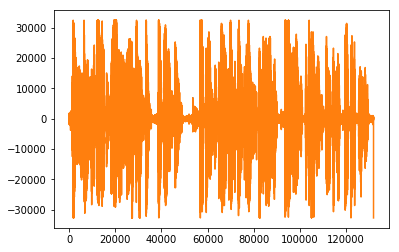

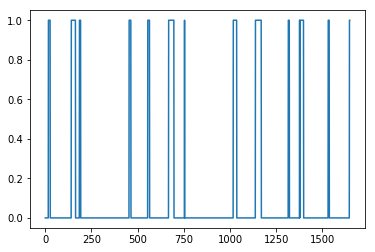

In [7]:
filename = r"C:\Users\Ravindran\Downloads\wavfiles\ENG_M.wav"
wfile,sr = scipy.io.wavfile.read(filename)
v = VoiceActivityDetector(filename)
data =  v.detect_speech()
v.plot_detected_speech_regions()

plt.plot(data[:,1])
plt.show()

In [8]:
np.mean(data[:,1])


0.10673135233474833

In [60]:
import collections
import contextlib
import sys
import wave

class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n

def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        print(sample_rate)
        assert sample_rate in (8000, 16000, 32000, 48000) 
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


In [95]:
import webrtcvad

def getValidFiles(dir_path):
    files = os.listdir(dir_path)
    vad = webrtcvad.Vad()
    vad.set_mode(2)
    for wav_file in files:
        try:
            pcm,sr = read_wave(dir_path+ '\\' +wav_file)
        except AssertionError as e:
            print(wav_file)
            continue
        mask = []
        frame_gen = frame_generator(20,pcm,sr)
        for frame in frame_gen:
            mask.append(vad.is_speech(frame.bytes,sr))
        print("{} , {}".format(wav_file,np.mean(mask)))
        

In [96]:
getValidFiles(r"C:\Users\Ravindran\Downloads\wavfiles")

8000
Busy Signal.wav-22689-Free-Loops.com.wav , 0.4935064935064935
8000
ENG_F.wav , 0.9932614555256065
8000
ENG_M.wav , 0.9333333333333333
8000
female.wav , 0.9975589910496339
8000
Imperial-March-Star-Wars.wav , 0.9933862433862434
8000
male.wav , 0.9976479811838495
8000
mask-100-550.wav , 0.8407005838198499
8000
old-phone-ringing.wav , 0.6245259165613148
8000
OutboundSampleRecording.wav , 0.8366461424025786
8000
tone-8Khz.wav , 0.48872180451127817


In [88]:
print(read_wave(r"C:\Users\Ravindran\Downloads\wavfiles\tone-8Khz.wav")) 

8000
(b'\x00\xff\x00\x02\x00\x07\x00\n\x00\x0e\x00\x13\x00\x16\x00\x1a\x00\x1e\x00"\x00&\x00*\x00-\x001\x004\x008\x00;\x00?\x00B\x00E\x00H\x00K\x00M\x00P\x00R\x00U\x00W\x00Y\x00[\x00\\\x00^\x00_\x00`\x00a\x00a\x00b\x00a\x00a\x00b\x00a\x00a\x00`\x00_\x00]\x00\\\x00Z\x00X\x00V\x00T\x00Q\x00N\x00K\x00H\x00D\x00A\x00=\x009\x005\x000\x00,\x00\'\x00#\x00\x1e\x00\x19\x00\x14\x00\x0f\x00\n\x00\x04\x00\xff\x00\xfa\x00\xf5\x00\xef\x00\xea\x00\xe5\x00\xe0\x00\xdb\x00\xd6\x00\xd1\x00\xcc\x00\xc7\x00\xc3\x00\xbf\x00\xba\x00\xb6\x00\xb3\x00\xaf\x00\xac\x00\xa9\x00\xa6\x00\xa3\x00\xa1\x00\x9f\x00\x9e\x00\x9c\x00\x9b\x00\x9a\x00\x9b\x00\x9b\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9f\x00\xa1\x00\xa3\x00\xa6\x00\xa9\x00\xac\x00\xb0\x00\xb4\x00\xb8\x00\xbd\x00\xc1\x00\xc6\x00\xcb\x00\xd1\x00\xd6\x00\xdd\x00\xe3\x00\xe8\x00\xef\x00\xf4\x00\xfb\x00\x01\x00\x08\x00\r\x00\x14\x00\x1b\x00 \x00\'\x00,\x002\x007\x00<\x00A\x00F\x00K\x00O\x00R\x00V\x00Y\x00[\x00^\x00_\x00a\x00a\x00a\x00b\x00a\x00a\x00_\x00]\x00[\x00